# Diffusion Models

Gregor Cerar  
2024-08-20

Abstract TODO

# Introduction

TODO

In [ ]:
from pathlib import Path

import numpy as np
import torch
from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = {'retina', 'png'}

# import torch.nn as nn
# import torch.optim as optim
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import transforms as VT


PROJECT_PATH = Path(".").resolve()
FIGURE_PATH = PROJECT_PATH / "figures"
DATASET_PATH = Path.home() / "datasets"

assert FIGURE_PATH.exists()
assert DATASET_PATH.exists()

N_WORKERS = 8
SEED = 42

BATCH_SIZE = 128
IMG_SIZE = 16
IMG_CH = 1

In [ ]:
AMP_ENABLED = False

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

    if torch.cuda.is_bf16_supported():
        AMP_ENABLED = True

In [24]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
# ddpm = ddpm_utils.DDPM(B, device)

In [26]:
def load_dataset(img_size: int, batch_size: int) -> tuple[ConcatDataset, DataLoader]:
    from torchvision.datasets import FashionMNIST

    transform = VT.Compose(
        [
            VT.Resize((img_size, img_size)),
            VT.ToTensor(),  # Scales data into [0,1]
            VT.RandomHorizontalFlip(),
            VT.Lambda(lambda t: (t * 2) - 1),  # Scale between [-1, 1]
        ]
    )

    train_set = FashionMNIST(DATASET_PATH, train=True, download=True, transform=transform)
    test_set = FashionMNIST(DATASET_PATH, train=False, download=True, transform=transform)
    dataset = ConcatDataset([train_set, test_set])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataset, dataloader


dataset, dataloader = load_dataset(IMG_SIZE, BATCH_SIZE)

In [27]:
class GELUConvBlock(nn.Module):
    def __init__(self, in_chs: int, out_chs: int, group_size: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(group_size, out_chs),
            nn.GELU(),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)

In [28]:
import einops

x = torch.rand(128, 3, 128, 128)
y = einops.rearrange(x, "b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

assert np.prod(x.shape) == np.prod(y.shape)

In [29]:
def show_image(x: np.ndarray):
    if len(x.shape) == 4:
        x = x[0, ...]

    vmin, vmax = np.min(x), np.max(x)
    n_channels = x.shape[0] if len(x.shape) == 3 else 1
    fig, axes = plt.subplots(nrows=1, ncols=n_channels, squeeze=False)

    for ch, ax in zip(range(n_channels), axes.flat, strict=True):
        ax.imshow(x[ch], cmap="viridis", interpolation="none", vmin=vmin, vmax=vmax)
        ax.axis("off")

    fig.tight_layout(pad=0.5)

    plt.show()

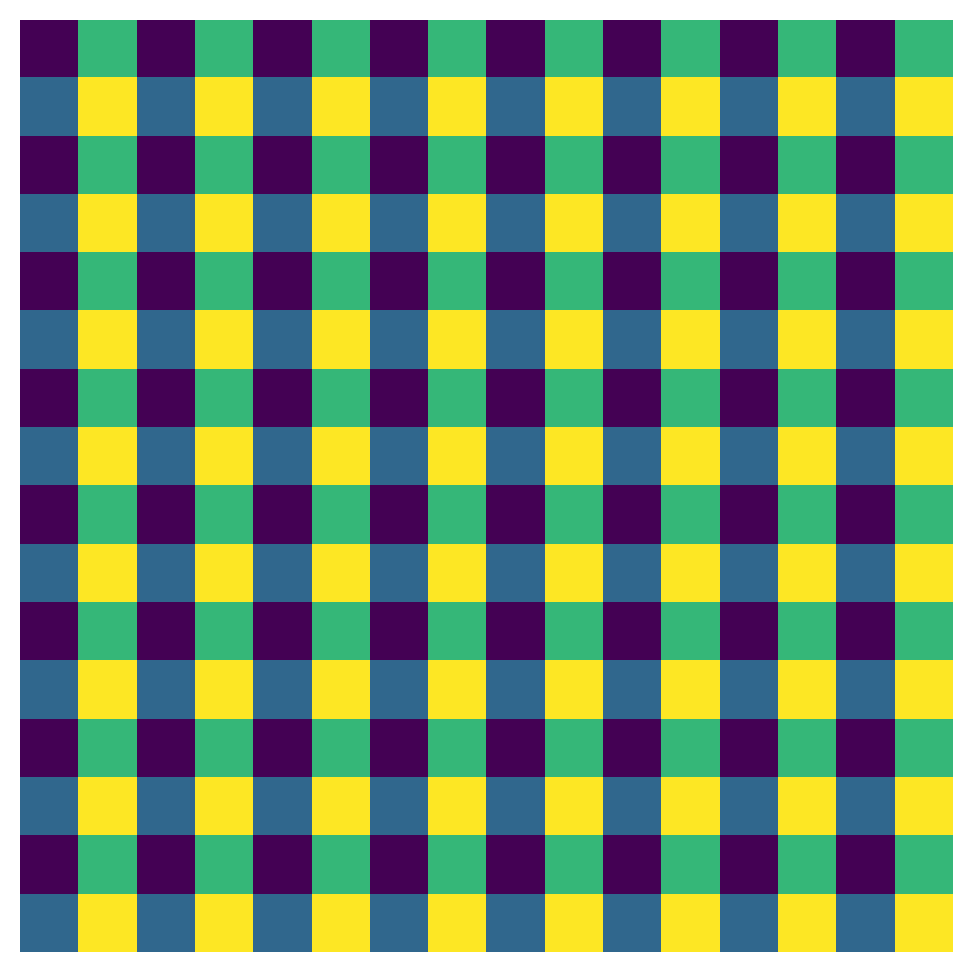

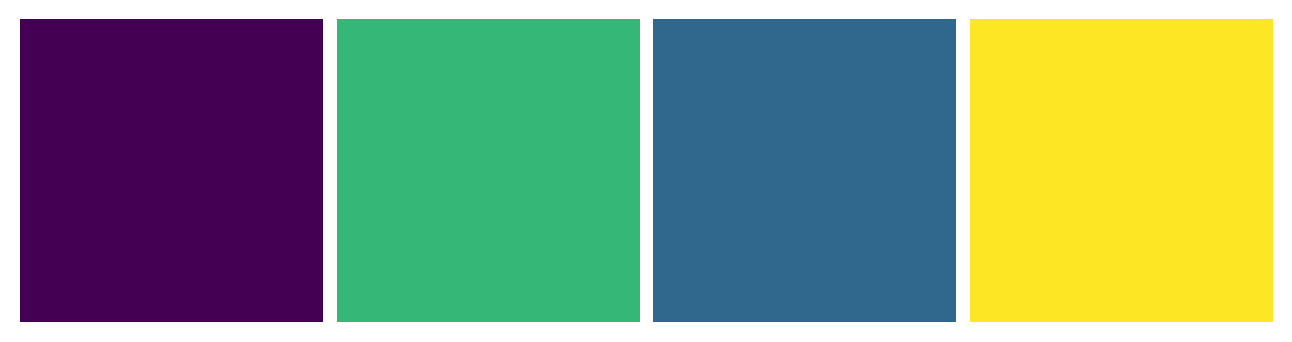

In [30]:
# Let's demonstrate what it does

# Define a base 2x2 pattern
base_pattern = torch.tensor([[0, 2], [1, 3]]) / 4

# Repeat the pattern to get a 16x16 checkerboard
checkerboard = base_pattern.repeat(8, 8)
x = checkerboard.reshape(1, 1, 16, 16)

show_image(x.numpy())

y = einops.rearrange(x, "b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
show_image(y.numpy())

In [31]:
from einops.layers.torch import Rearrange


class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs: int, group_size: int):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x: Tensor) -> Tensor:
        x = self.rearrange(x)
        return self.conv(x)

In [32]:
class DownBlock(nn.Module):
    def __init__(self, in_chs: int, out_chs: int, group_size: int):
        super().__init__()
        self.layers = nn.Sequential(
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        )

    def forward(self, x):
        return self.layers(x)

In [33]:
class UpBlock(nn.Module):
    def __init__(self, in_chs: int, out_chs: int, group_size: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size=2, stride=2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        )

    def forward(self, x: Tensor, skip: Tensor) -> Tensor:
        x = torch.cat((x, skip), 1)
        x = self.layers(x)
        return x

In [34]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs: int, out_chs: int, group_size: int):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [35]:
import math


class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: Tensor) -> Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10_000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [36]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim: int, emb_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [37]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4  # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base
        big_group_size = 8 * group_size_base

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )

        # Time embeddings (temb)
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim)
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1),
        )

    def forward(self, x: Tensor, t: Tensor):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t)

        up0 = self.up0(latent_vec)

        temb_1 = self.temb_1(t)
        up1 = self.up1(up0 + temb_1, down2)

        temb_2 = self.temb_2(t)
        up2 = self.up2(up1 + temb_2, down1)

        return self.out(torch.cat((up2, down0), 1))

In [38]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777

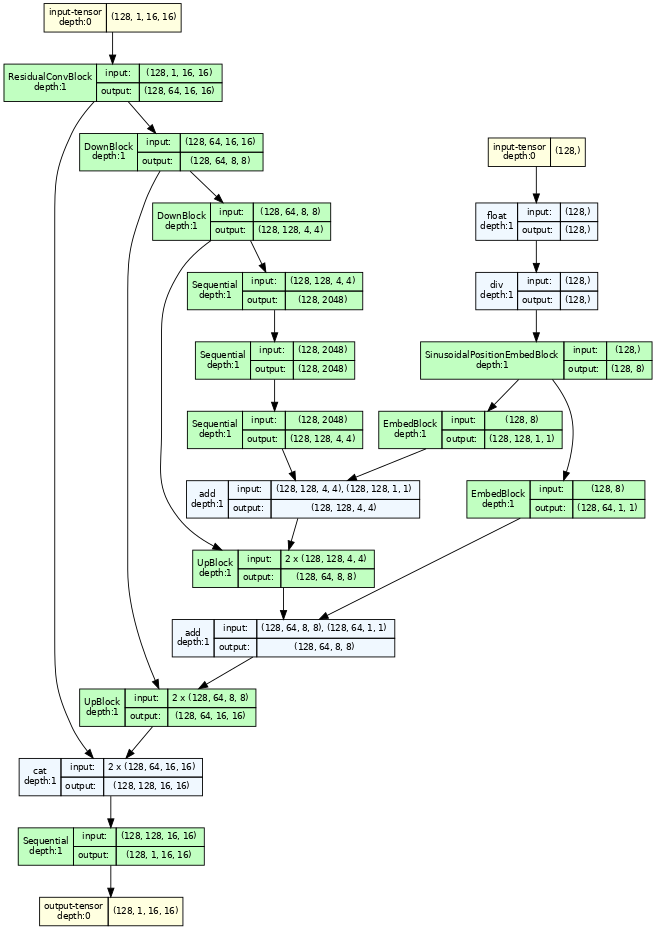

In [39]:
#!pip install graphviz torchview
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format("png")
model_graph = draw_graph(
    UNet(),
    input_size=((BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE), (BATCH_SIZE,)),
    device="meta",
    depth=1,
    expand_nested=False,
    graph_dir="TD",
    graph_name="U-Net with Positional Embeddings",
)
model_graph.resize_graph(scale=0.75)
model_graph.visual_graph

In [40]:
def show_tensor_image(image):
    reverse_transforms = VT.Compose(
        [
            VT.Lambda(lambda t: (t + 1) / 2),
            VT.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
            VT.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
            VT.ToPILImage(),
        ]
    )
    plt.imshow(reverse_transforms(image[0].detach().cpu()))


class DDPM:
    def __init__(self, B: Tensor, device: torch.device):
        self.B = B
        self.T = len(B)
        self.device = device

        # Forward diffusion variables
        self.a = 1.0 - self.B
        self.a_bar = torch.cumprod(self.a, dim=0)
        self.sqrt_a_bar = torch.sqrt(self.a_bar)  # Mean Coefficient
        self.sqrt_one_minus_a_bar = torch.sqrt(1 - self.a_bar)  # St. Dev. Coefficient

        # Reverse diffusion variables
        self.sqrt_a_inv = torch.sqrt(1 / self.a)
        self.pred_noise_coeff = (1 - self.a) / torch.sqrt(1 - self.a_bar)

    def q(self, x_0: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        """
        The forward diffusion process
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = self.sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = self.sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

    def get_loss(self, model: nn.Module, x_0: Tensor, t: Tensor, *model_args):
        x_noisy, noise = self.q(x_0, t)
        noise_pred = model(x_noisy, t, *model_args)
        return F.mse_loss(noise, noise_pred)

    @torch.no_grad()
    def reverse_q(self, x_t: Tensor, t: Tensor, e_t: Tensor):
        """
        The reverse diffusion process
        Returns the an image with the noise from time t removed and time t-1 added.
        model: the model used to remove the noise
        x_t: the noisy image at time t
        t: timestep
        model_args: additional arguments to pass to the model
        """
        t = t.int()
        pred_noise_coeff_t = self.pred_noise_coeff[t]
        sqrt_a_inv_t = self.sqrt_a_inv[t]
        u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
        if t[0] == 0:  # All t values should be the same
            return u_t  # Reverse diffusion complete!
        else:
            B_t = self.B[t - 1]  # Apply noise from the previos timestep
            new_noise = torch.randn_like(x_t)
            return u_t + torch.sqrt(B_t) * new_noise

    @torch.no_grad()
    def sample_images(self, model: UNet, img_ch: int, img_size: int, ncols: int, *model_args, axis_on=False):
        # Noise to generate images from
        x_t = torch.randn((1, img_ch, img_size, img_size), device=self.device)
        hidden_rows = self.T / ncols

        # plt.figure(figsize=(8, 8))
        # Go from T to 0 removing and adding noise until t = 0
        imgs: list[np.ndarray] = []
        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=self.device).float()
            e_t = model(x_t, t, *model_args)  # Predicted noise
            x_t = self.reverse_q(x_t, t, e_t)
            if i % hidden_rows == 0:
                imgs.append(x_t.detach().squeeze().cpu().numpy())

        fig, axes = plt.subplots(ncols=len(imgs), figsize=(8, 8 * len(imgs)), frameon=False)
        for img, ax in zip(imgs, axes.flatten(), strict=True):
            ax.imshow(img, cmap="viridis", interpolation="none")
            ax.axis("off")

        fig.tight_layout(pad=0.3)
        plt.show()

In [41]:
ddpm = DDPM(B, device)

Epoch 0 | step 000 Loss: 1.095550537109375 

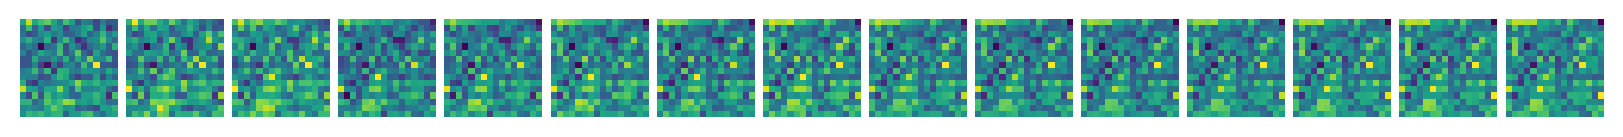

Epoch 0 | step 100 Loss: 0.1664707362651825 

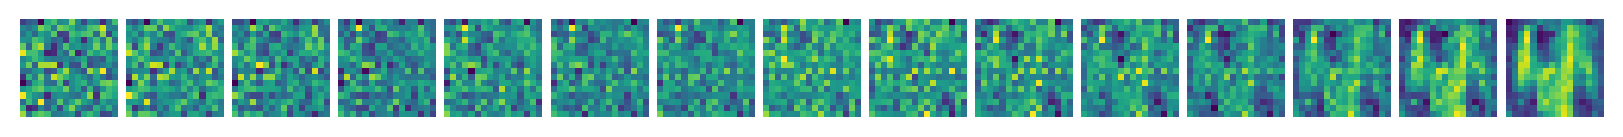

Epoch 0 | step 200 Loss: 0.12925593554973602 

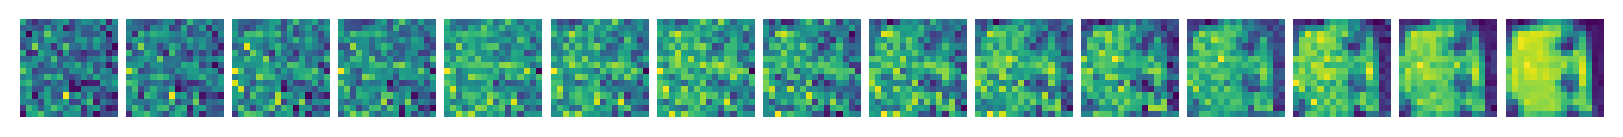

Epoch 0 | step 300 Loss: 0.11227521300315857 

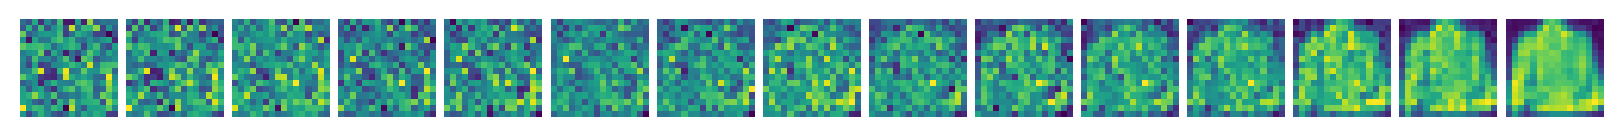

Epoch 0 | step 400 Loss: 0.11387482285499573 

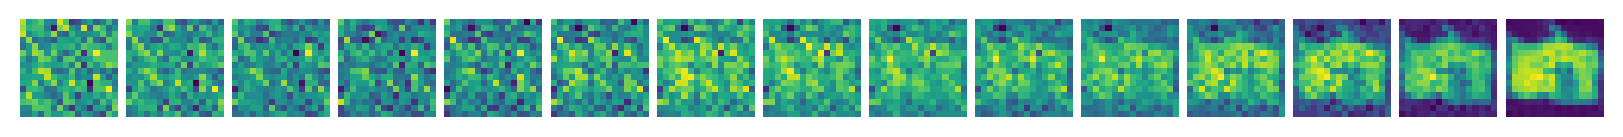

Epoch 0 | step 500 Loss: 0.130568265914917 

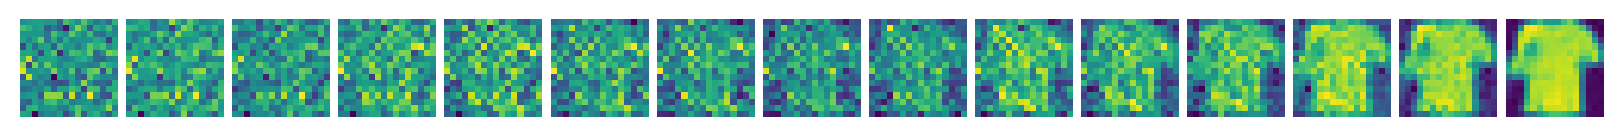

Epoch 2 | step 000 Loss: 0.11149217188358307 

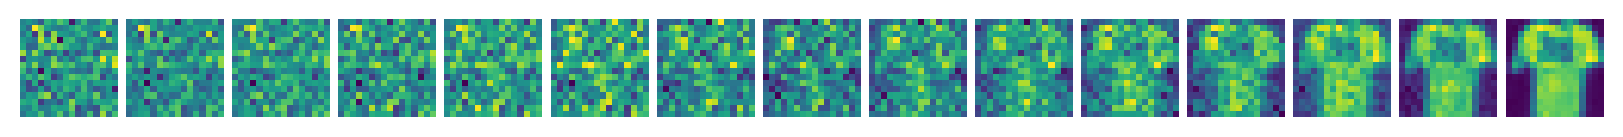

Epoch 2 | step 100 Loss: 0.09133929014205933 

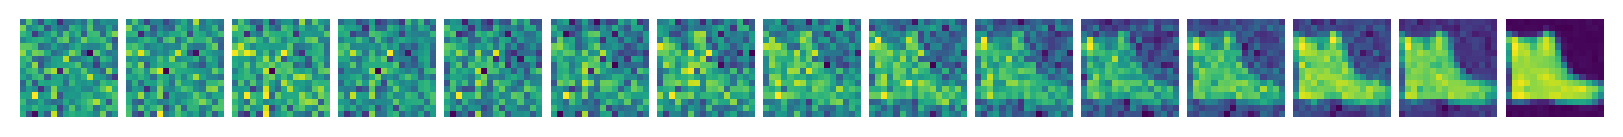

Epoch 2 | step 200 Loss: 0.10428953915834427 

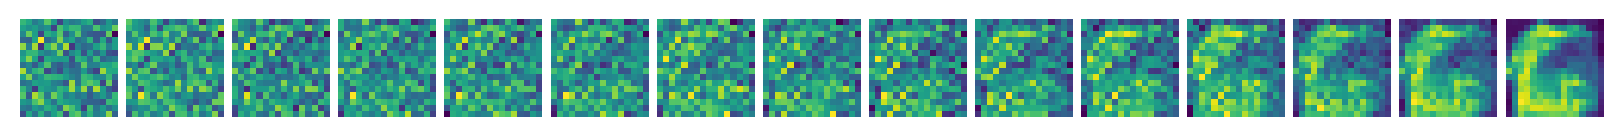

Epoch 2 | step 300 Loss: 0.10355056822299957 

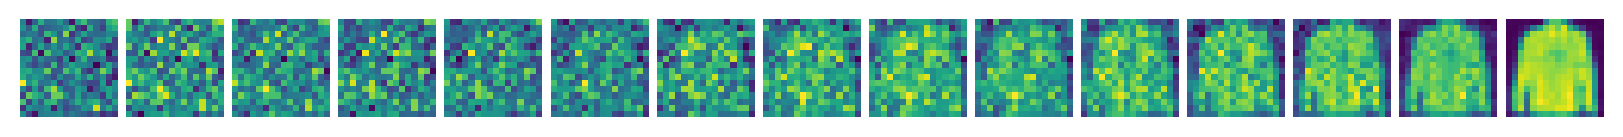

Epoch 2 | step 400 Loss: 0.09006781131029129 

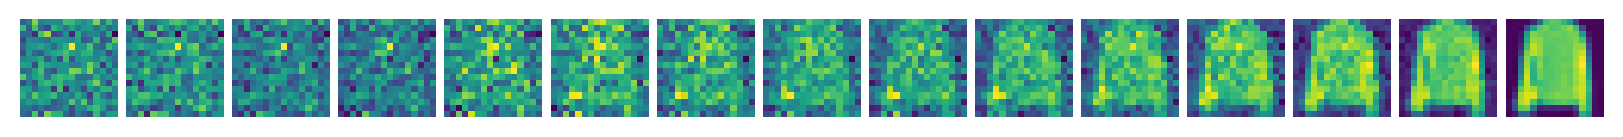

Epoch 2 | step 500 Loss: 0.09721481800079346 

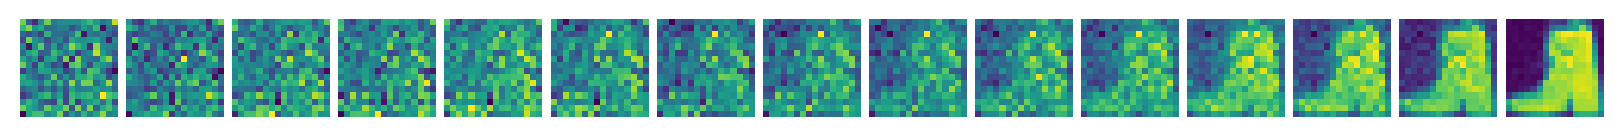

Epoch 4 | step 000 Loss: 0.09983102977275848 

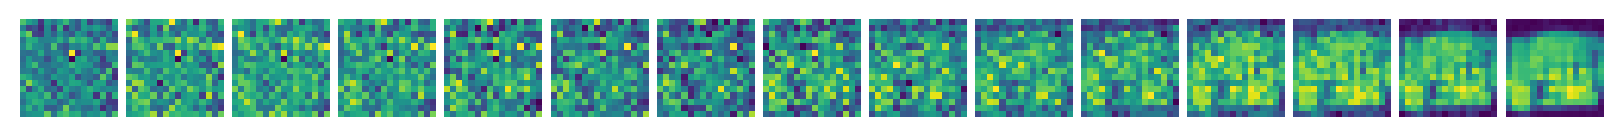

Epoch 4 | step 100 Loss: 0.0956757515668869 

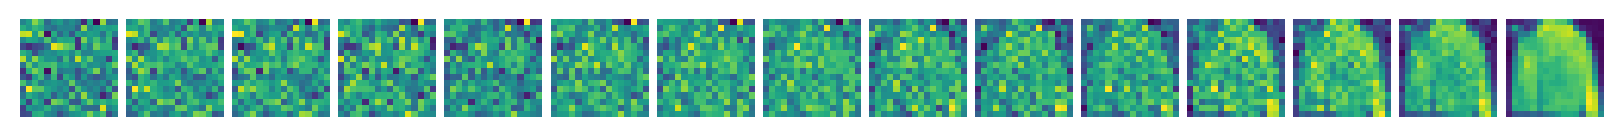

Epoch 4 | step 200 Loss: 0.10748287290334702 

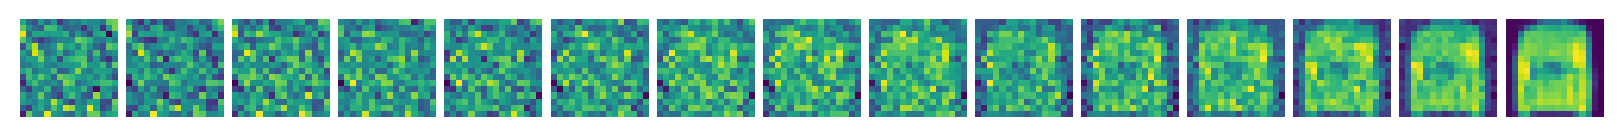

Epoch 4 | step 300 Loss: 0.09318585693836212 

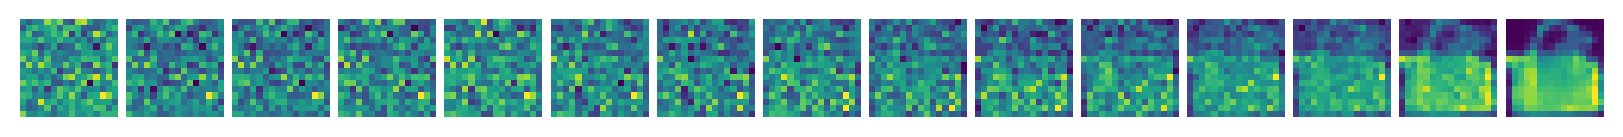

Epoch 4 | step 400 Loss: 0.09129081666469574 

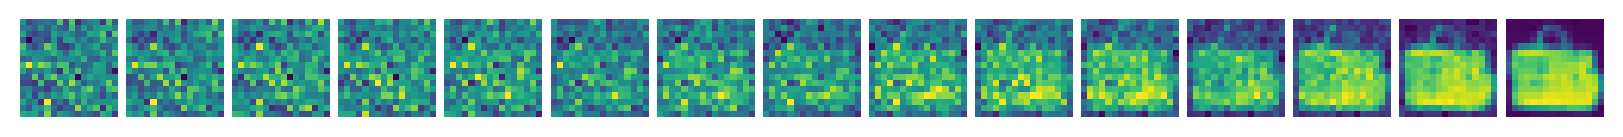

Epoch 4 | step 500 Loss: 0.07993844151496887 

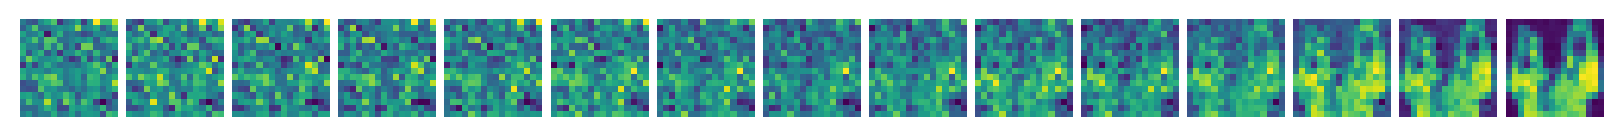

In [42]:
model = UNet().to(device)
model.compile()

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 2 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

In [ ]:
### Classifier Free version